In [1]:
# ha senso analizzare un solo giocatore e addestrare con i suoi dati?
#come scegliere p e q guardando i grafici di autocorrelazione parziale e non
#true e false nel predict

In [2]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install datetime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os as os
from datetime import datetime

In [2]:
percorso_csv = r"../../csv_post_etl"
 
df_appearances = pd.read_csv(percorso_csv + "/appearances_post.csv")
df_club_games = pd.read_csv(percorso_csv + "/club_games_post.csv")
df_clubs = pd.read_csv(percorso_csv + "/clubs_post.csv")
df_competitions = pd.read_csv(percorso_csv + "/competitions_post.csv")
df_game_events = pd.read_csv(percorso_csv + "/game_events_post.csv")
df_game_lineups = pd.read_csv(percorso_csv + "/game_lineups_post.csv")
df_games = pd.read_csv(percorso_csv + "/games_post.csv")
df_player_valuations = pd.read_csv(percorso_csv + "/player_valuations_post.csv")
df_players = pd.read_csv(percorso_csv + "/players_post.csv")

In [3]:
df_per_previsione = df_player_valuations[["date", "market_value_in_eur", "player_id"]]
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

# Trova i giocatori che hanno almeno una data nel 2023
players_with_2023_dates = df_per_previsione[df_per_previsione['date'].dt.year == 2023]['player_id'].unique()

# Filtra il DataFrame originale per i giocatori trovati
df_per_previsione = df_per_previsione[df_per_previsione['player_id'].isin(players_with_2023_dates)]

# Stampa il DataFrame risultante
#print(df_per_previsione)

C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\2884229399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])


In [4]:
pd.reset_option("display.max_row")
df_appearances['date'] = pd.to_datetime(df_appearances['date'])

player_gol = df_appearances.groupby(['player_id', df_appearances['date'].dt.to_period("M")]).agg({'goals': 'sum', 'assists': 'sum', 'red_cards':'sum'}).reset_index()

player_gol["date"] = player_gol["date"].dt.to_timestamp()
print(player_gol)


        player_id       date  goals  assists  red_cards
0              10 2012-08-01      1        0          0
1              10 2012-09-01      3        1          0
2              10 2012-10-01      3        0          0
3              10 2012-11-01      2        0          0
4              10 2012-12-01      2        0          0
...           ...        ...    ...      ...        ...
512047    1173042 2023-12-01      0        0          0
512048    1176345 2023-11-01      0        0          0
512049    1176345 2023-12-01      0        0          0
512050    1186012 2023-11-01      0        0          0
512051    1186012 2023-12-01      0        0          0

[512052 rows x 5 columns]


In [5]:
#pd.set_option('display.max_row', None)
df_per_previsione['date'] = df_per_previsione['date'].dt.to_period('M').dt.to_timestamp()
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

#Espandi il DataFrame
expanded_data = []

#Raggruppa per player_id
for player_id, group in df_per_previsione.groupby('player_id'):
    player_data = group.sort_values('date')
    
    #Crea un DataFrame con tutte le date del mese e giorno 1
    all_dates = pd.date_range(player_data['date'].min(), player_data['date'].max(), freq='MS')
    all_dates_df = pd.DataFrame({'date': all_dates})
    
    # Unisci il DataFrame con tutte le date con i dati esistenti
    player_data_expanded = pd.merge(all_dates_df, player_data, on='date', how='left')
    
    # Riempie le date mancanti con i valori precedenti/futuri già esistenti
    player_data_expanded['market_value_in_eur'] = player_data_expanded['market_value_in_eur'].ffill().bfill()
    player_data_expanded['player_id'] = player_data_expanded['player_id'].ffill().bfill()

    expanded_data.append(player_data_expanded)

# Concatena tutti i DataFrame espansi
df_expanded = pd.concat(expanded_data, ignore_index=True)

In [6]:
df_expanded.to_csv('../../csv_post_etl/serie_temp_post.csv', index=False)

In [7]:
df_previsione_post_etl = pd.read_csv(percorso_csv + "/serie_temp_post.csv")


In [10]:
print(df_previsione_post_etl)

               date  market_value_in_eur  player_id
0        2004-10-01            7500000.0      215.0
1        2004-11-01            4000000.0      215.0
2        2004-12-01            4000000.0      215.0
3        2005-01-01            4000000.0      215.0
4        2005-02-01            4000000.0      215.0
...             ...                  ...        ...
1781115  2023-12-01             150000.0  1173042.0
1781116  2023-12-01             150000.0  1176345.0
1781117  2023-10-01             100000.0  1186012.0
1781118  2023-11-01             100000.0  1186012.0
1781119  2023-12-01             350000.0  1186012.0

[1781120 rows x 3 columns]


In [8]:
#print(df_expanded)
#pd.set_option("display.max_row", None)
pd.reset_option("display.max_row")

df_previsione_post_etl['date'] = pd.to_datetime(df_previsione_post_etl['date'])

df_previsione_post_etl = pd.merge(df_previsione_post_etl, player_gol, on = ["player_id", "date"], how = "left")
print(df_previsione_post_etl)



              date  market_value_in_eur  player_id  goals  assists  red_cards
0       2004-10-01            7500000.0      215.0    NaN      NaN        NaN
1       2004-11-01            4000000.0      215.0    NaN      NaN        NaN
2       2004-12-01            4000000.0      215.0    NaN      NaN        NaN
3       2005-01-01            4000000.0      215.0    NaN      NaN        NaN
4       2005-02-01            4000000.0      215.0    NaN      NaN        NaN
...            ...                  ...        ...    ...      ...        ...
1781115 2023-12-01             150000.0  1173042.0    0.0      0.0        0.0
1781116 2023-12-01             150000.0  1176345.0    0.0      0.0        0.0
1781117 2023-10-01             100000.0  1186012.0    NaN      NaN        NaN
1781118 2023-11-01             100000.0  1186012.0    0.0      0.0        0.0
1781119 2023-12-01             350000.0  1186012.0    0.0      0.0        0.0

[1781120 rows x 6 columns]


In [9]:
df_previsione_post_etl["player_id"] = df_previsione_post_etl["player_id"].astype(int)
df_previsione_post_etl = df_previsione_post_etl.set_index('date')

In [10]:
print(df_previsione_post_etl)

            market_value_in_eur  player_id  goals  assists  red_cards
date                                                                 
2004-10-01            7500000.0        215    NaN      NaN        NaN
2004-11-01            4000000.0        215    NaN      NaN        NaN
2004-12-01            4000000.0        215    NaN      NaN        NaN
2005-01-01            4000000.0        215    NaN      NaN        NaN
2005-02-01            4000000.0        215    NaN      NaN        NaN
...                         ...        ...    ...      ...        ...
2023-12-01             150000.0    1173042    0.0      0.0        0.0
2023-12-01             150000.0    1176345    0.0      0.0        0.0
2023-10-01             100000.0    1186012    NaN      NaN        NaN
2023-11-01             100000.0    1186012    0.0      0.0        0.0
2023-12-01             350000.0    1186012    0.0      0.0        0.0

[1781120 rows x 5 columns]


C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\258999970.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data_to_plot["market_value_in_eur"] = (player_data_to_plot["market_value_in_eur"] - min_mv) / (max_mv - min_mv)
C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\258999970.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data_to_plot["goals"] = (player_data_to_plot["goals"] - min_gol) / (max_gol - min_gol)
C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\258999970.py:25: Settin

            market_value_in_eur  player_id     goals  assists  red_cards   eta
date                                                                          
2016-12-01                  0.0     418560  0.000000      NaN        NaN  16.0
2017-01-01                  0.0     418560  0.000000      NaN        NaN  16.0
2017-02-01                  0.0     418560  0.000000      NaN        NaN  16.0
2017-03-01                  0.0     418560  0.000000      NaN        NaN  16.0
2017-04-01                  0.0     418560  0.000000      NaN        NaN  16.0
...                         ...        ...       ...      ...        ...   ...
2023-08-01                  1.0     418560  0.333333      0.0        0.0  23.0
2023-09-01                  1.0     418560  0.555556      2.0        0.0  23.0
2023-10-01                  1.0     418560  0.555556      1.0        0.0  23.0
2023-11-01                  1.0     418560  0.666667      1.0        0.0  23.0
2023-12-01                  1.0     418560  0.000000

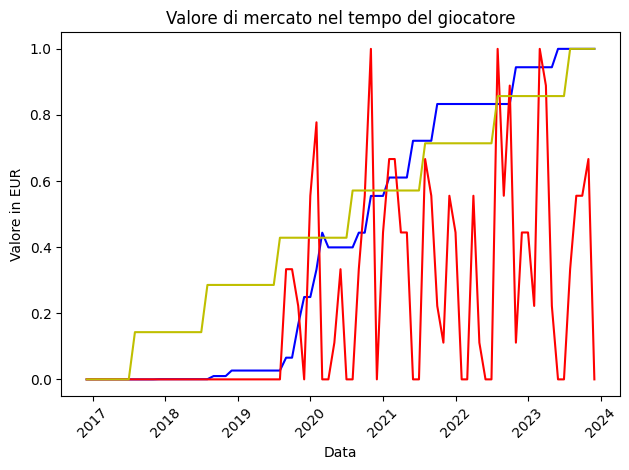

In [139]:
# Specifica il player_id del giocatore di interesse
player_id_to_plot = 418560
  # Cambia questo valore con l'id del giocatore desiderato
data_nascita = df_players["date_of_birth"][df_players["player_id"] == player_id_to_plot].values
data_nascita = pd.to_datetime(data_nascita)
# Filtra il DataFrame per il giocatore specifico
player_data_to_plot = df_previsione_post_etl[df_previsione_post_etl["player_id"] == player_id_to_plot]
 
# Calcola la media e la deviazione standard della colonna "diff"
min_mv = player_data_to_plot["market_value_in_eur"].min()
max_mv = player_data_to_plot["market_value_in_eur"].max()
 
# Standardizza la colonna "diff"
player_data_to_plot["market_value_in_eur"] = (player_data_to_plot["market_value_in_eur"] - min_mv) / (max_mv - min_mv)
 
# Calcola la media e la deviazione standard della colonna "diff"
min_gol = player_data_to_plot["goals"].min()
max_gol = player_data_to_plot["goals"].max()


 
#player_data_to_plot["goals"] = player_data_to_plot["goals"].fillna(mean_diff_gol, inplace=True)
# Standardizza la colonna "diff"
player_data_to_plot["goals"] = (player_data_to_plot["goals"] - min_gol) / (max_gol - min_gol)
player_data_to_plot["goals"].fillna(min_gol, inplace=True)


 
player_data_to_plot["eta"] = (player_data_to_plot.index - data_nascita[0]).days//365.25
print(player_data_to_plot)

min_eta = player_data_to_plot["eta"].min()
max_eta = player_data_to_plot["eta"].max()

player_data_to_plot["eta"] = (player_data_to_plot["eta"] - min_eta) / (max_eta - min_eta)
player_data_to_plot["eta"].fillna(min_gol, inplace=True)
 
 
# Crea il plot mondiale supremo
plt.plot(player_data_to_plot.index, player_data_to_plot["market_value_in_eur"], linestyle='-', color='b')
plt.plot(player_data_to_plot.index, player_data_to_plot["goals"], linestyle='-', color='r')
plt.plot(player_data_to_plot.index, player_data_to_plot["eta"], linestyle='-', color='y')
 
 
# Personalizza il plot
plt.title(f'Valore di mercato nel tempo del giocatore')
plt.xlabel('Data')
plt.ylabel('Valore in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità
 
# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/serie_temp_id_{player_id_to_plot}.png")
plt.show()

C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\557920505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series['lag'] = differenced_series['market_value_in_eur'].shift(1)


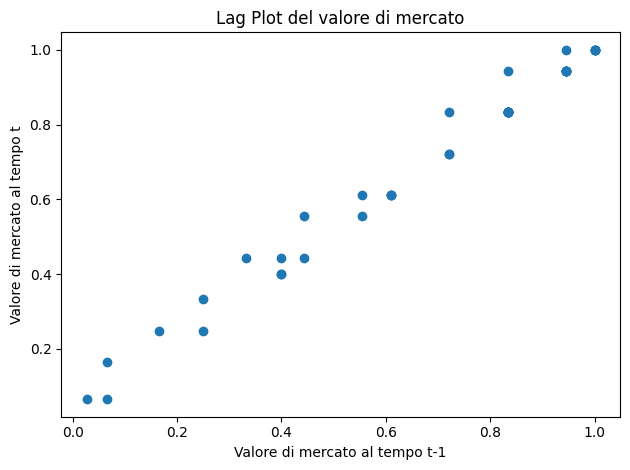

In [140]:
differenced_series = player_data_to_plot
# Aggiungi colonne con i valori ritardati (lag) al dataframe
differenced_series['lag'] = differenced_series['market_value_in_eur'].shift(1)

# Rimuovi le prime righe che avranno valori NaN a causa dello shift
differenced_series = differenced_series.dropna()

plt.scatter(differenced_series['lag'], differenced_series['market_value_in_eur'])

# Personalizza il plot
plt.title('Lag Plot del valore di mercato')
plt.xlabel('Valore di mercato al tempo t-1')
plt.ylabel('Valore di mercato al tempo t')

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/lag_plot_serie_temp_id_{player_id_to_plot}.png")

# Mostra il plot
plt.show()

In [141]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [142]:
#qui rifacciamo l'assegnamento perchè prima eliminavamo le righe con i NaN
differenced_series = player_data_to_plot
print(differenced_series)

            market_value_in_eur  player_id     goals  assists  red_cards  eta  \
date                                                                            
2016-12-01                  0.0     418560  0.000000      NaN        NaN  0.0   
2017-01-01                  0.0     418560  0.000000      NaN        NaN  0.0   
2017-02-01                  0.0     418560  0.000000      NaN        NaN  0.0   
2017-03-01                  0.0     418560  0.000000      NaN        NaN  0.0   
2017-04-01                  0.0     418560  0.000000      NaN        NaN  0.0   
...                         ...        ...       ...      ...        ...  ...   
2023-08-01                  1.0     418560  0.333333      0.0        0.0  1.0   
2023-09-01                  1.0     418560  0.555556      2.0        0.0  1.0   
2023-10-01                  1.0     418560  0.555556      1.0        0.0  1.0   
2023-11-01                  1.0     418560  0.666667      1.0        0.0  1.0   
2023-12-01                  

In [143]:
test_stationarity(differenced_series['market_value_in_eur'])

Test Statistic           0.280953
p-value                  0.976454
Lags                     0.000000
Observations            84.000000
Critical Value (1%)     -3.510712
Critical Value (5%)     -2.896616
Critical Value (10%)    -2.585482
dtype: float64


In [144]:
# Esegui la differenziazione della serie temporale
differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()
print(differenced_series["diff"])

# Esegui nuovamente il test di stazionarietà sulla serie differenziata
test_stationarity(differenced_series["diff"].dropna())

date
2016-12-01    NaN
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
             ... 
2023-08-01    0.0
2023-09-01    0.0
2023-10-01    0.0
2023-11-01    0.0
2023-12-01    0.0
Name: diff, Length: 85, dtype: float64
Test Statistic         -8.933701e+00
p-value                 9.660907e-15
Lags                    0.000000e+00
Observations            8.300000e+01
Critical Value (1%)    -3.511712e+00
Critical Value (5%)    -2.897048e+00
Critical Value (10%)   -2.585713e+00
dtype: float64


C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\3684567774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()


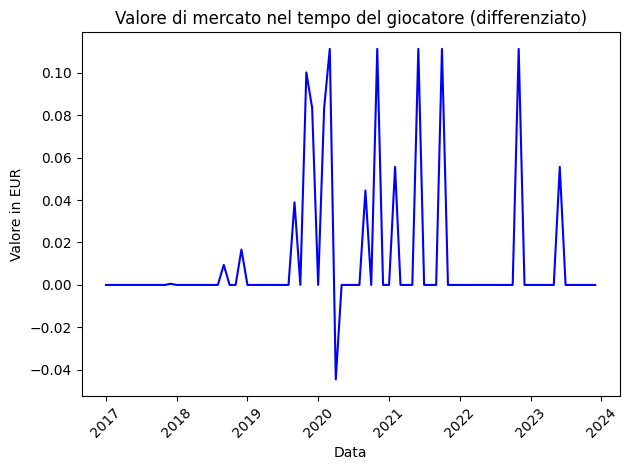

In [145]:
plt.plot(differenced_series.index, differenced_series["diff"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Valore di mercato nel tempo del giocatore (differenziato)')
plt.xlabel('Data')
plt.ylabel('Valore in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/serie_temp_diff_id_{player_id_to_plot}.png")
plt.show()

date
2016-12-01    NaN
2017-01-01    0.0
2017-02-01    0.0
2017-03-01    0.0
2017-04-01    0.0
             ... 
2023-08-01    0.0
2023-09-01    0.0
2023-10-01    0.0
2023-11-01    0.0
2023-12-01    0.0
Name: diff, Length: 85, dtype: float64


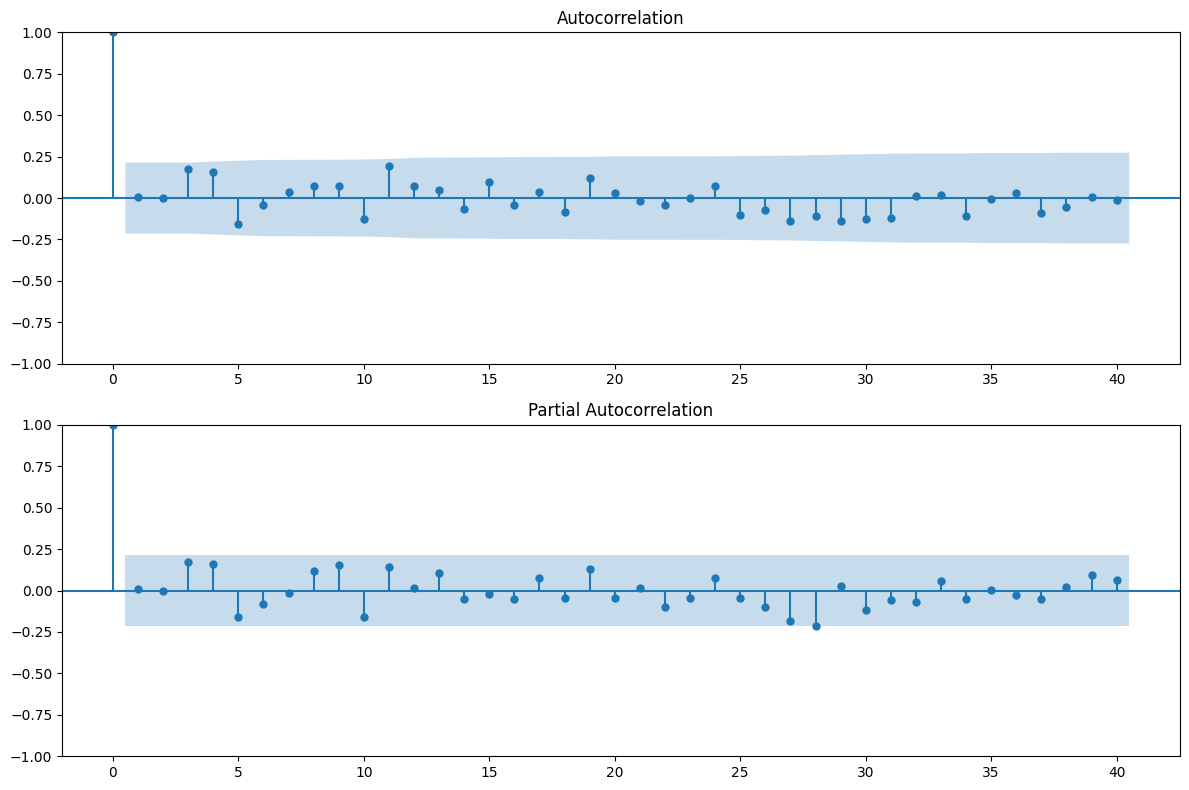

In [146]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series["diff"])
fig = sm.graphics.tsa.plot_acf(differenced_series["diff"][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series["diff"][1:], lags=40, ax=ax2)

plt.tight_layout()
plt.savefig(f"../../images/ac_pac_player_{player_id_to_plot}.png")

In [147]:
differenced_series["goals"].fillna(differenced_series["goals"].mean(), inplace=True)
print(differenced_series["goals"])

test_stationarity(differenced_series["goals"]) #questo differenzio



date
2016-12-01    0.000000
2017-01-01    0.000000
2017-02-01    0.000000
2017-03-01    0.000000
2017-04-01    0.000000
                ...   
2023-08-01    0.333333
2023-09-01    0.555556
2023-10-01    0.555556
2023-11-01    0.666667
2023-12-01    0.000000
Name: goals, Length: 85, dtype: float64
Test Statistic          -2.499902
p-value                  0.115498
Lags                     3.000000
Observations            81.000000
Critical Value (1%)     -3.513790
Critical Value (5%)     -2.897943
Critical Value (10%)    -2.586191
dtype: float64


C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\4258999571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["goals"].fillna(differenced_series["goals"].mean(), inplace=True)


In [148]:
differenced_series["diff_goal"] = differenced_series['goals'].diff()
print(differenced_series["diff_goal"])

# Esegui nuovamente il test di stazionarietà sulla serie differenziata
mean_fill_value = differenced_series["diff_goal"].mean().round()
differenced_series["diff_goal"].fillna(mean_fill_value, inplace=True)


test_stationarity(differenced_series["diff_goal"])

date
2016-12-01         NaN
2017-01-01    0.000000
2017-02-01    0.000000
2017-03-01    0.000000
2017-04-01    0.000000
                ...   
2023-08-01    0.333333
2023-09-01    0.222222
2023-10-01    0.000000
2023-11-01    0.111111
2023-12-01   -0.666667
Name: diff_goal, Length: 85, dtype: float64
Test Statistic         -6.729657e+00
p-value                 3.320801e-09
Lags                    5.000000e+00
Observations            7.900000e+01
Critical Value (1%)    -3.515977e+00
Critical Value (5%)    -2.898886e+00
Critical Value (10%)   -2.586694e+00
dtype: float64


C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\574997820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff_goal"] = differenced_series['goals'].diff()
C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\574997820.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff_goal"].fillna(mean_fill_value, inplace=True)


In [149]:
test_stationarity(differenced_series["eta"])

differenced_series["diff_eta"] = differenced_series['eta'].diff()
differenced_series["diff_eta"].fillna(0, inplace=True)

test_stationarity(differenced_series["diff_eta"])

Test Statistic          -1.844121
p-value                  0.358787
Lags                    12.000000
Observations            72.000000
Critical Value (1%)     -3.524624
Critical Value (5%)     -2.902607
Critical Value (10%)    -2.588679
dtype: float64
Test Statistic         -1.176435e+15
p-value                 0.000000e+00
Lags                    1.200000e+01
Observations            7.200000e+01
Critical Value (1%)    -3.524624e+00
Critical Value (5%)    -2.902607e+00
Critical Value (10%)   -2.588679e+00
dtype: float64


C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\934520512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff_eta"] = differenced_series['eta'].diff()
C:\Users\gissi\AppData\Local\Temp\ipykernel_20212\934520512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff_eta"].fillna(0, inplace=True)


date
2016-12-01   -0.000000
2017-01-01    0.000000
2017-02-01    0.000000
2017-03-01    0.000000
2017-04-01    0.000000
                ...   
2023-08-01    0.333333
2023-09-01    0.222222
2023-10-01    0.000000
2023-11-01    0.111111
2023-12-01   -0.666667
Name: diff_goal, Length: 85, dtype: float64


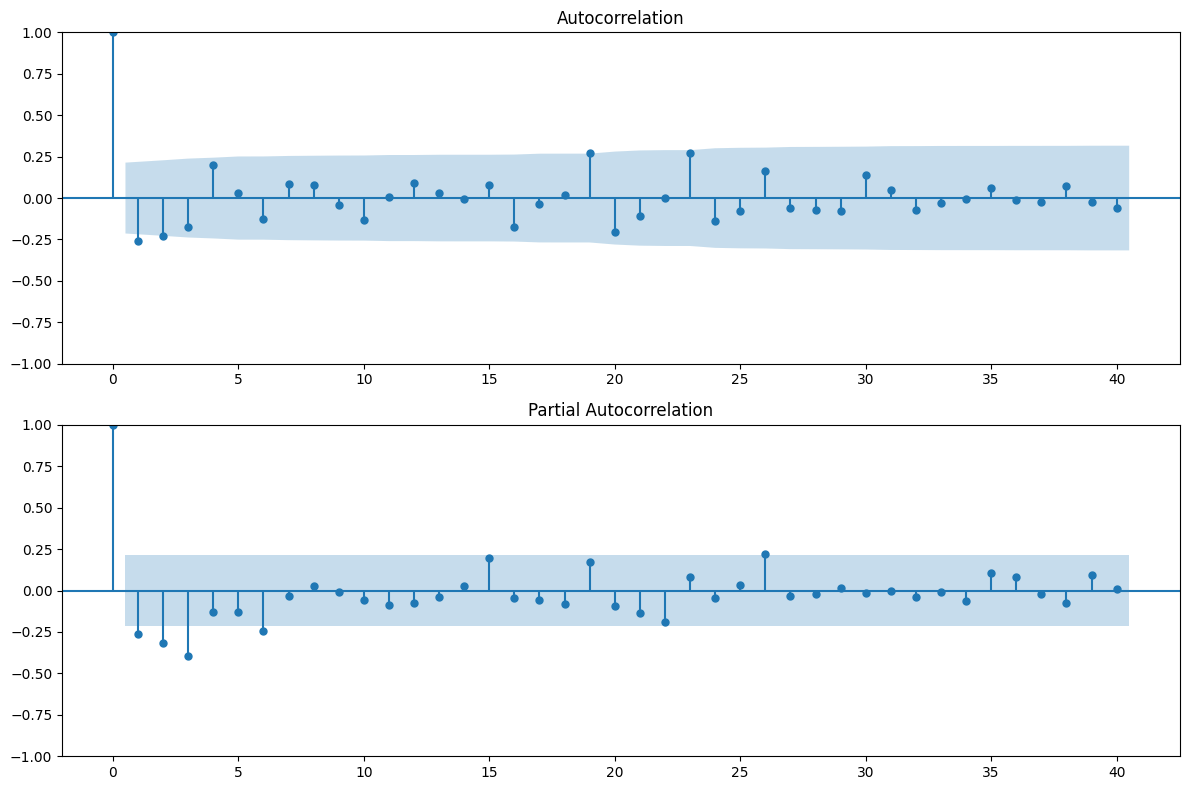

In [150]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series["diff_goal"])
fig = sm.graphics.tsa.plot_acf(differenced_series["diff_goal"][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series["diff_goal"][1:], lags=40, ax=ax2)

plt.tight_layout()
plt.savefig(f"../../images/ac_pac_player_diff_gol.png")

c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     market_value_in_eur   No. Observations:                   85
Model:                  ARIMA(0, 1, 0)   Log Likelihood                 164.530
Date:                 Tue, 16 Jan 2024   AIC                           -327.060
Time:                         17:06:26   BIC                           -324.630
Sample:                     12-01-2016   HQIC                          -326.083
                          - 12-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   9.15e-05     12.725      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               129.76
Prob(Q):                              0

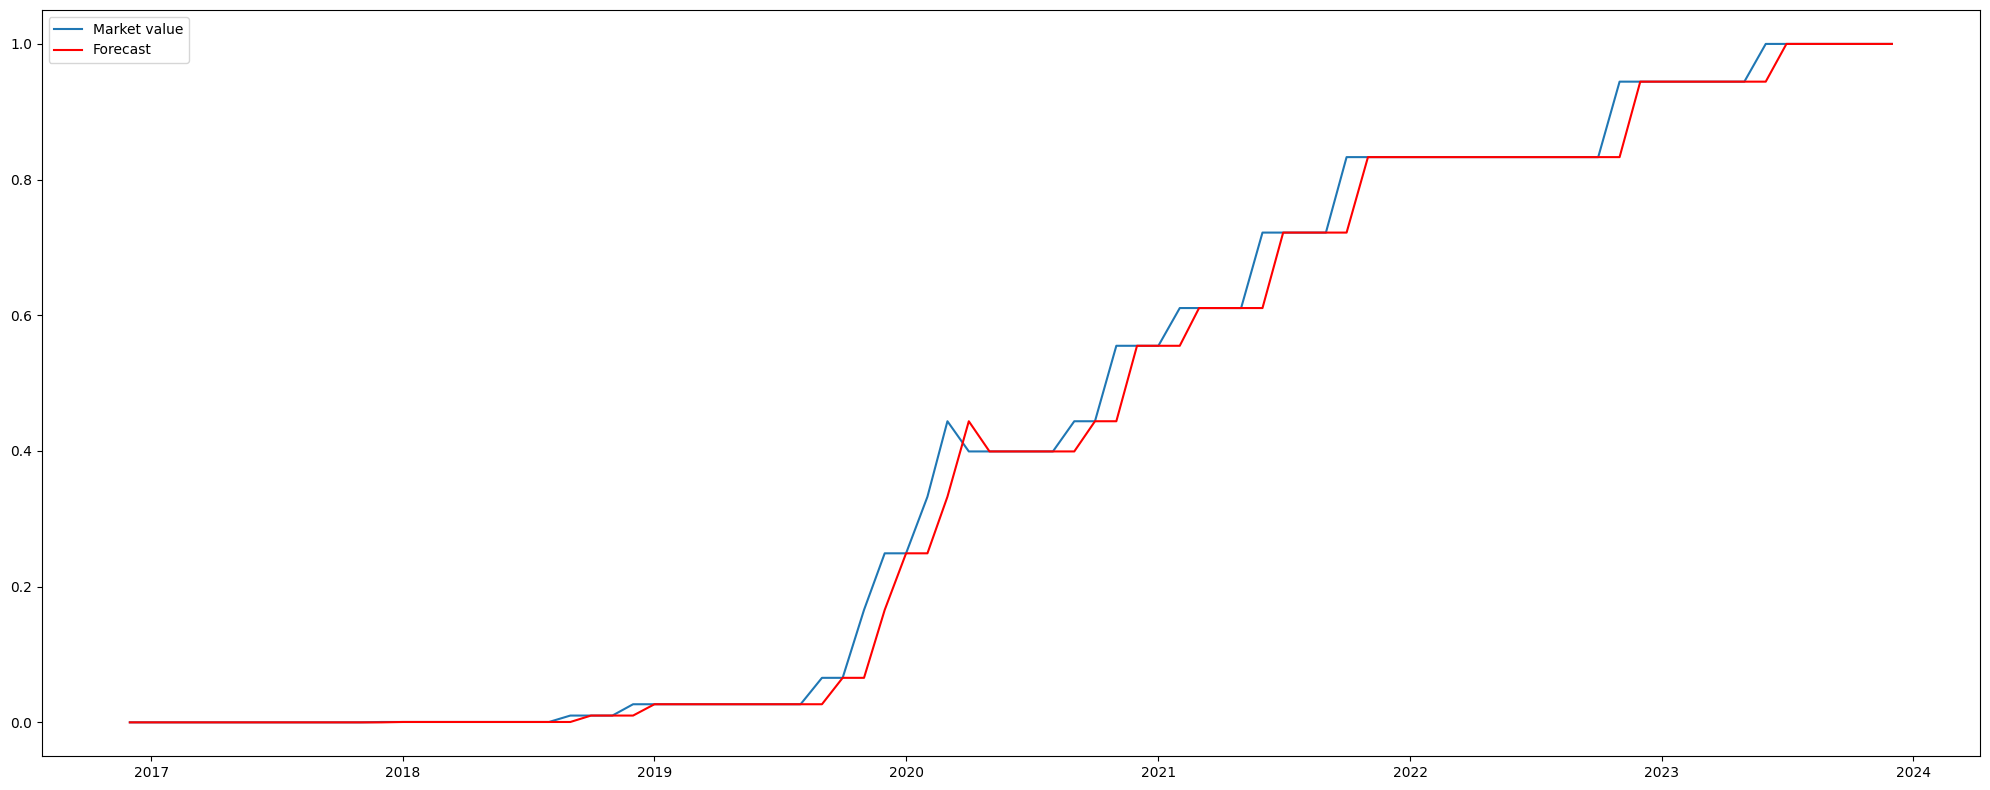

In [176]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(endog=differenced_series["market_value_in_eur"], order=(0,1,0)) #chiedi al prof se devi mettere (0,1,0) sembra overfittare troppo
ax = plt.gca()
results = model.fit()
plt.plot(differenced_series["market_value_in_eur"])
#plt.plot(differenced_series["goals"])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Market value', 'Forecast'])
plt.tight_layout()
plt.savefig(f"../../images/model_ARIMA_player_{player_id_to_plot}.png")

print(results.summary())

c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     market_value_in_eur   No. Observations:                   85
Model:                  ARIMA(0, 1, 0)   Log Likelihood                 166.783
Date:                 Tue, 16 Jan 2024   AIC                           -329.566
Time:                         17:06:40   BIC                           -324.705
Sample:                     12-01-2016   HQIC                          -327.612
                          - 12-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff_goal     -0.0156      0.007     -2.161      0.031      -0.030      -0.001
sigma2         0.0011      0.000     10.301      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01  

'\n- z (Statistica z): Il valore della statistica z è associato al coefficiente stimato e indica quanti errori standard è il coefficiente lontano \ndallo zero. Nel tuo caso, il valore di z per diff_goal è prossimo a 0.010.\n\n- P>|z| (Valore p): Il valore p (P>|z|) è la probabilità che il coefficiente diff_goal sia effettivamente zero (non significativo). \nIn questo caso, il valore p è prossimo a 0.992.\n\nLa statistica z vicina a zero suggerisce che il coefficiente diff_goal non è significativamente diverso da zero.\nIl valore p elevato (vicino a 0.992) conferma questa osservazione e suggerisce che il coefficiente diff_goal non è statisticamente significativo.\nIn altre parole, dal punto di vista statistico, sembra che il termine diff_goal non abbia un impatto significativo sulla tua variabile dipendente,\nalmeno in base alle informazioni fornite dalle statistiche z e p-value nel tuo modello ARIMA.\nPotresti considerare la possibilità di esaminare ulteriormente la validità del termin

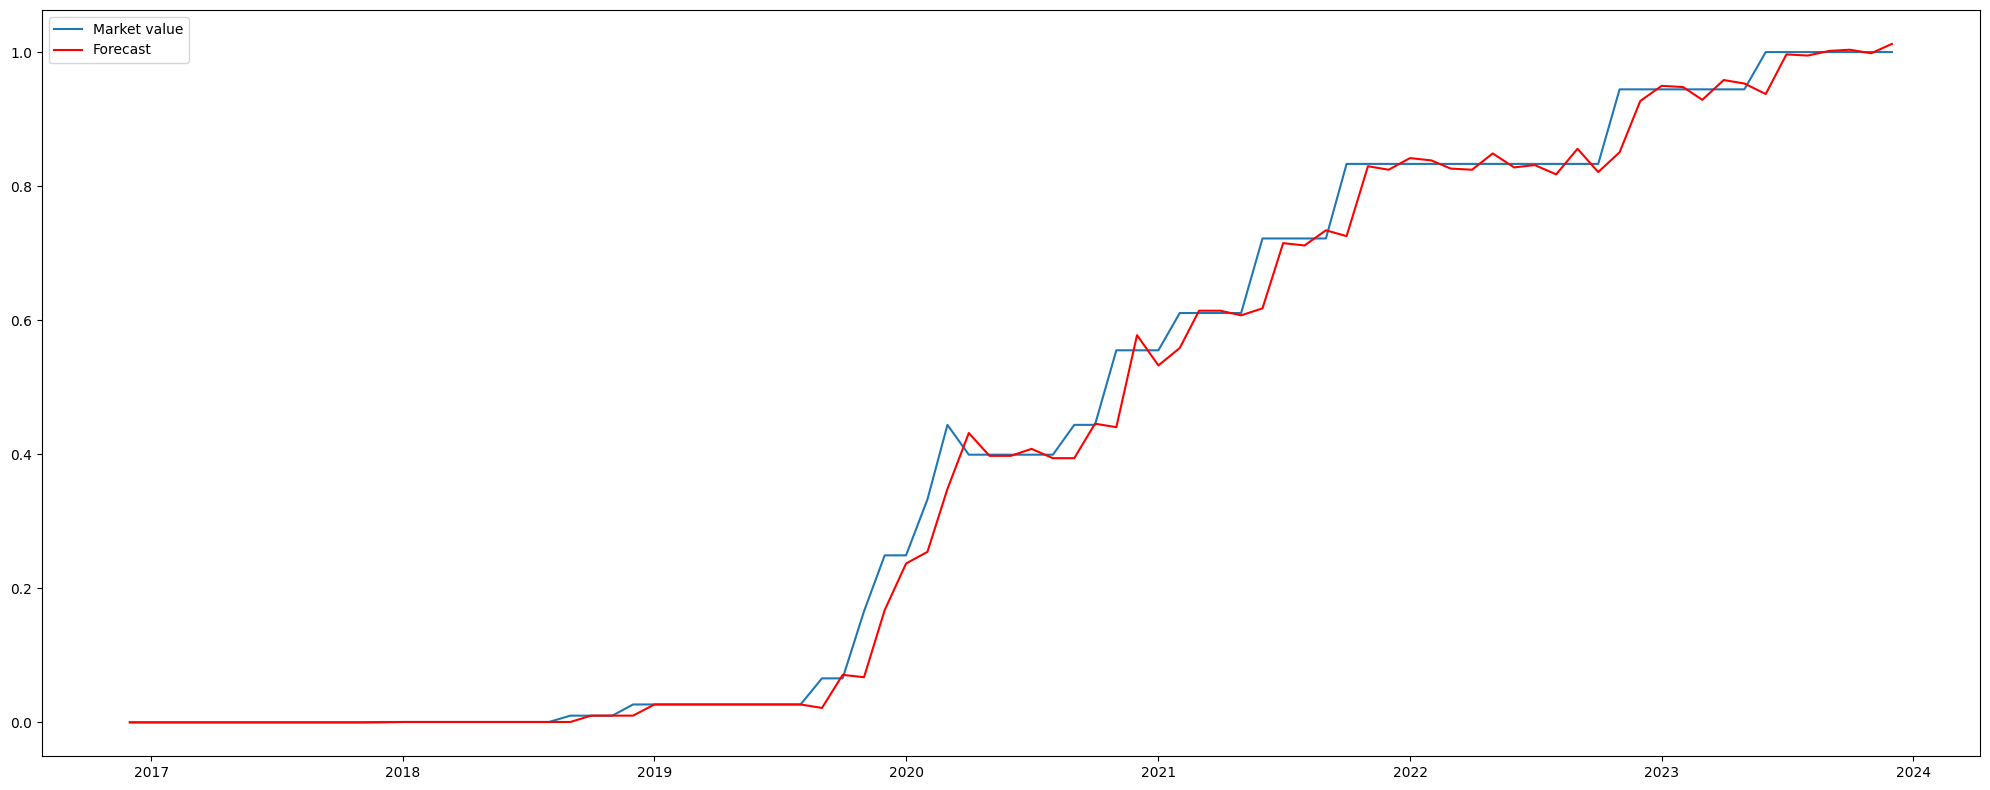

In [177]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
#devi fare gli attaccanti con i gol, poichè al ruolo att è legato maggiormente il prezzo al gol, per il dif/cen NOOOOO!!!!
model1 = ARIMA(endog=differenced_series["market_value_in_eur"], exog=differenced_series[["diff_goal"]], order=(0,1,0))
ax = plt.gca()
results1 = model1.fit()
plt.plot(differenced_series["market_value_in_eur"])
#plt.plot(differenced_series["goals"])
plt.plot(results1.fittedvalues, color='red')
ax.legend(['Market value', 'Forecast'])
plt.tight_layout()
plt.savefig(f"../../images/model_ARIMA_player_{player_id_to_plot}.png")

print(results1.summary())

'''
- z (Statistica z): Il valore della statistica z è associato al coefficiente stimato e indica quanti errori standard è il coefficiente lontano 
dallo zero. Nel tuo caso, il valore di z per diff_goal è prossimo a 0.010.

- P>|z| (Valore p): Il valore p (P>|z|) è la probabilità che il coefficiente diff_goal sia effettivamente zero (non significativo). 
In questo caso, il valore p è prossimo a 0.992.

La statistica z vicina a zero suggerisce che il coefficiente diff_goal non è significativamente diverso da zero.
Il valore p elevato (vicino a 0.992) conferma questa osservazione e suggerisce che il coefficiente diff_goal non è statisticamente significativo.
In altre parole, dal punto di vista statistico, sembra che il termine diff_goal non abbia un impatto significativo sulla tua variabile dipendente,
almeno in base alle informazioni fornite dalle statistiche z e p-value nel tuo modello ARIMA.
Potresti considerare la possibilità di esaminare ulteriormente la validità del termine esogeno diff_goal o esplorare altre variabili che 
potrebbero avere un impatto maggiore sulla tua serie temporale.
'''

c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\gissi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     market_value_in_eur   No. Observations:                   85
Model:                  ARIMA(0, 1, 0)   Log Likelihood                 164.796
Date:                 Tue, 16 Jan 2024   AIC                           -325.591
Time:                         17:06:50   BIC                           -320.729
Sample:                     12-01-2016   HQIC                          -323.637
                          - 12-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff_eta      -0.0464      0.149     -0.312      0.755      -0.338       0.245
sigma2         0.0012   9.06e-05     12.772      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00  

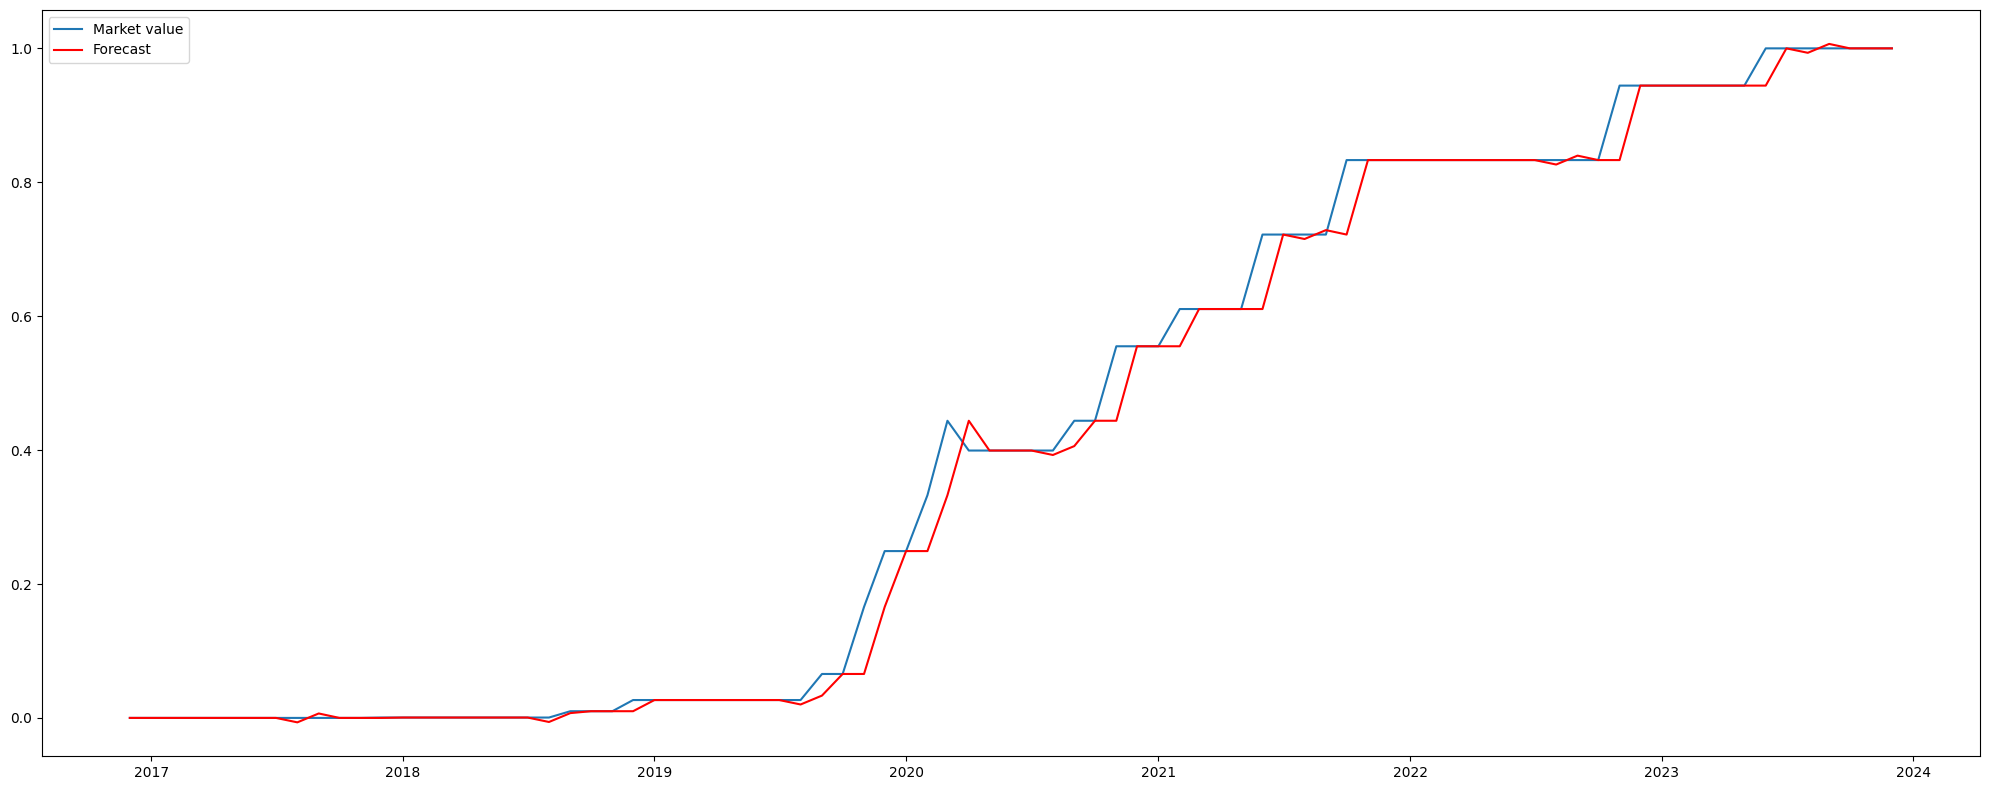

In [178]:
#addestramento con età

# fit ARIMA model
fig = plt.figure(figsize=(20,8))
#devi fare gli attaccanti con i gol, poichè al ruolo att è legato maggiormente il prezzo al gol, per il dif/cen NOOOOO!!!!
model2 = ARIMA(endog=differenced_series["market_value_in_eur"], exog=differenced_series[["diff_eta"]], order=(0,1,0))
ax = plt.gca()
results2 = model2.fit()
plt.plot(differenced_series["market_value_in_eur"])
#plt.plot(differenced_series["goals"])
plt.plot(results2.fittedvalues, color='red')
ax.legend(['Market value', 'Forecast'])
plt.tight_layout()
plt.savefig(f"../../images/model_ARIMA_player_{player_id_to_plot}.png")

print(results2.summary())


In [154]:
numero_righe = len(differenced_series)
print(numero_righe)

85


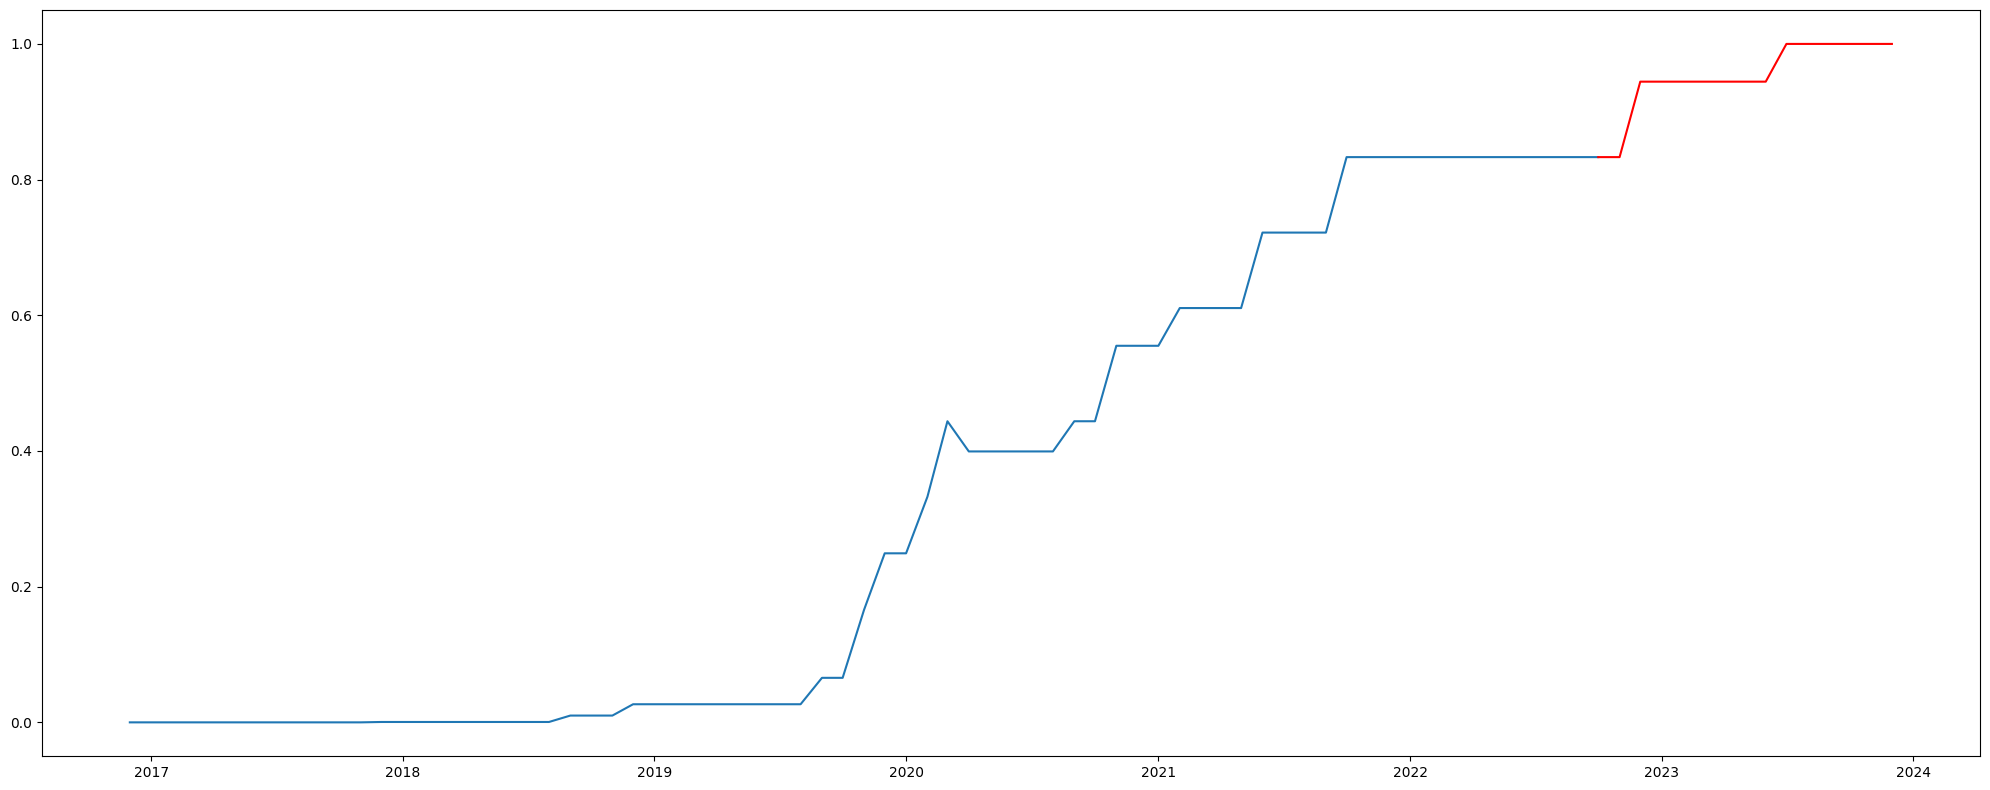

In [179]:
fig = plt.figure(figsize=(20,8))
num_points = len(differenced_series['market_value_in_eur'])
x = results.predict(start=(70), end=(84), dynamic=False)
plt.plot(differenced_series['market_value_in_eur'][:71])
plt.plot(x, color='r')
plt.tight_layout()
plt.savefig(f"../../images/prediction_ARIMA_player_{player_id_to_plot}.png")

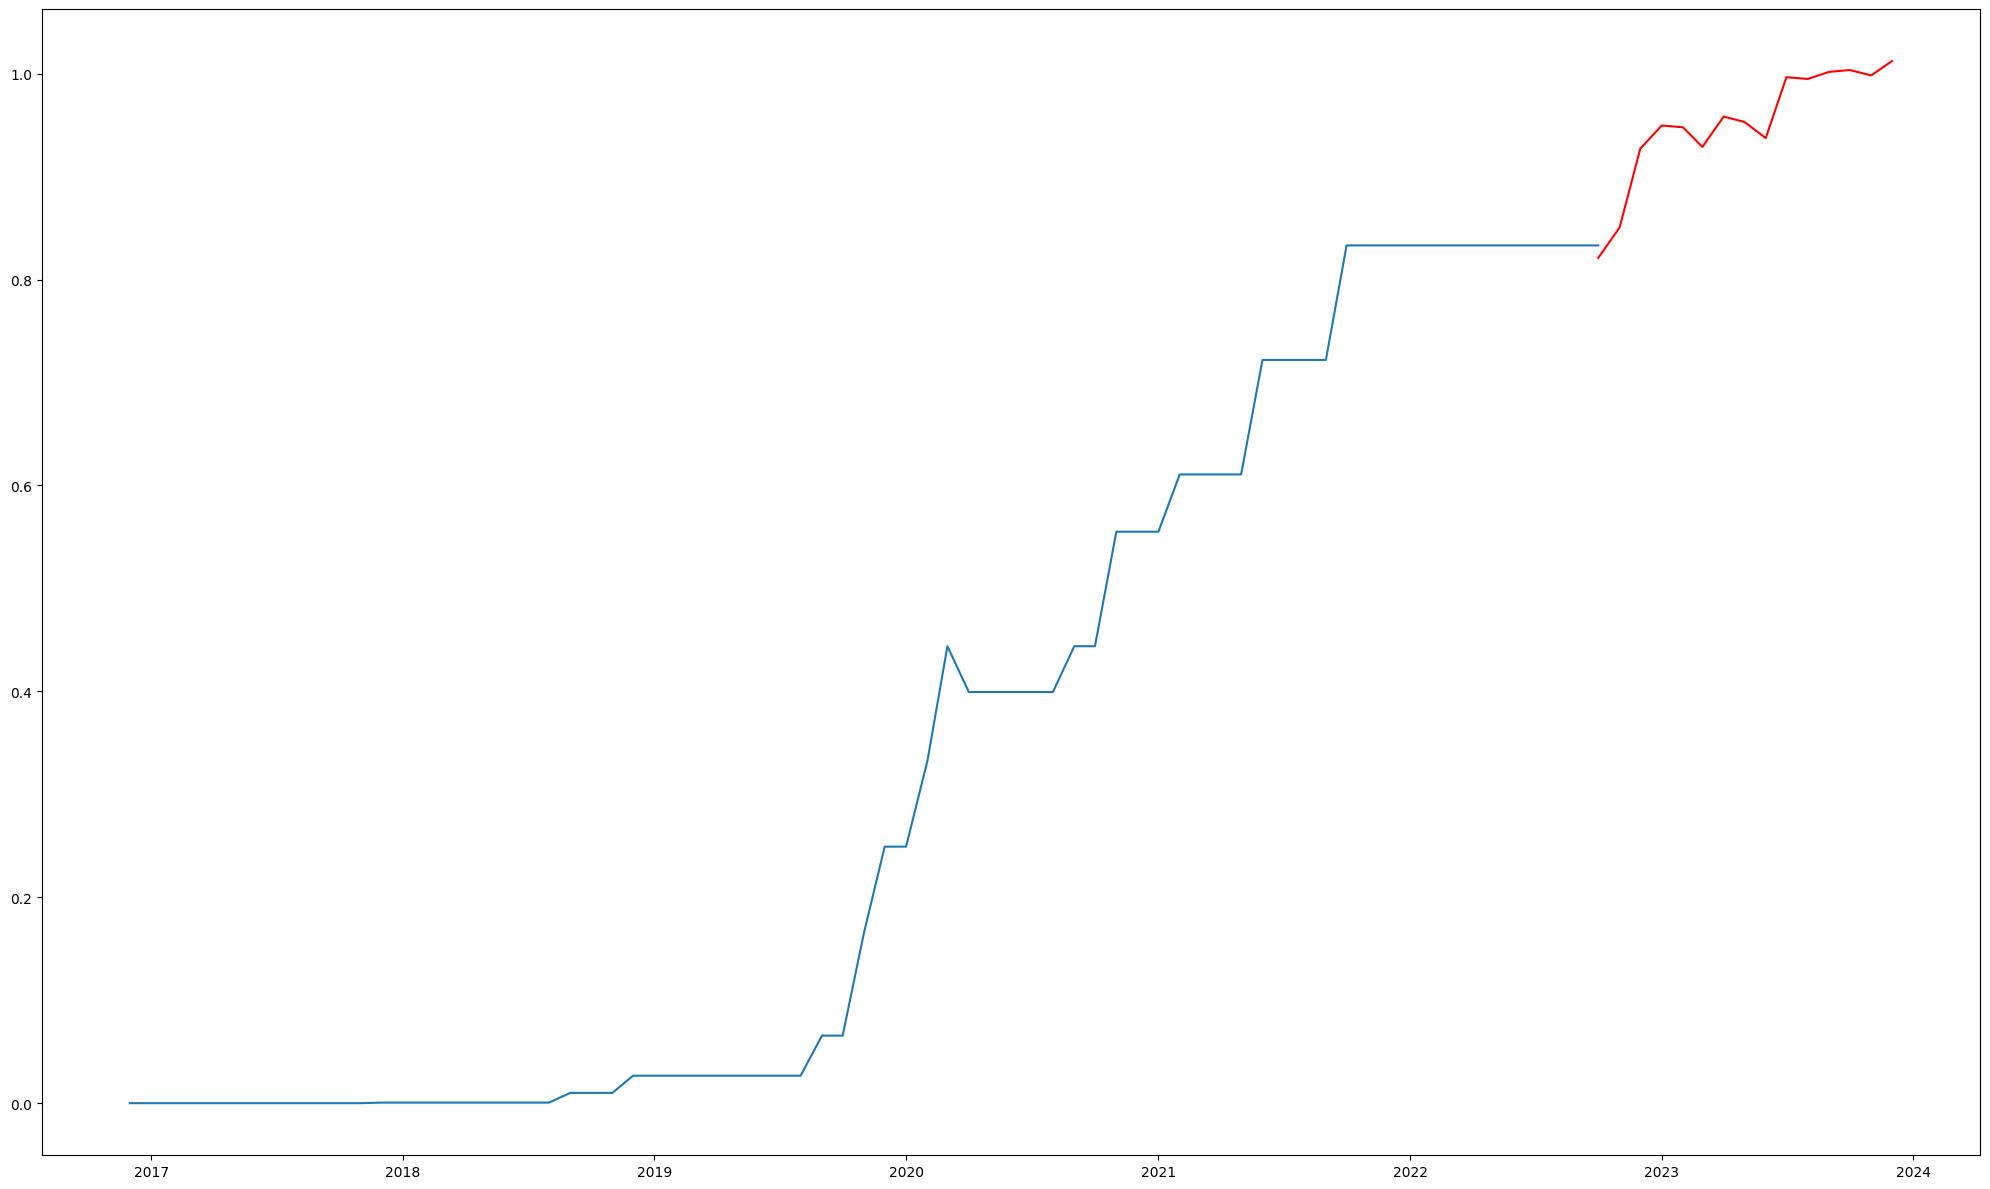

In [180]:
fig = plt.figure(figsize=(20,12))
num_points = len(differenced_series['market_value_in_eur'])
x = results1.predict(start=(70), end=(84), dynamic=False)
plt.plot(differenced_series['market_value_in_eur'][:71])
plt.plot(x, color='r')
plt.tight_layout()
plt.savefig(f"../../images/prediction_ARIMAX_player_{player_id_to_plot}.png")

In [161]:
numero_righe = len(differenced_series["diff_goal"])
print(numero_righe)

85


market_value_in_eur      mean   mean_se  mean_ci_lower  mean_ci_upper
2024-01-01           0.980891  0.033220       0.915781       1.046002
2024-02-01           0.986103  0.046980       0.894023       1.078183
2024-03-01           1.001737  0.057539       0.888963       1.114511
2024-04-01           0.989577  0.066440       0.859357       1.119798
2024-05-01           0.987840  0.074282       0.842249       1.133431
2024-06-01           0.986103  0.081372       0.826616       1.145590
2024-07-01           0.994789  0.087892       0.822523       1.167054
2024-08-01           0.989577  0.093961       0.805417       1.173737
2024-09-01           0.984366  0.099660       0.789035       1.179697
2024-10-01           0.986103  0.105051       0.780206       1.192000
2024-11-01           0.982629  0.110179       0.766682       1.198575
2024-12-01           1.005211  0.115078       0.779663       1.230760
2025-01-01           0.982629  0.119777       0.747870       1.217387
2025-02-01          

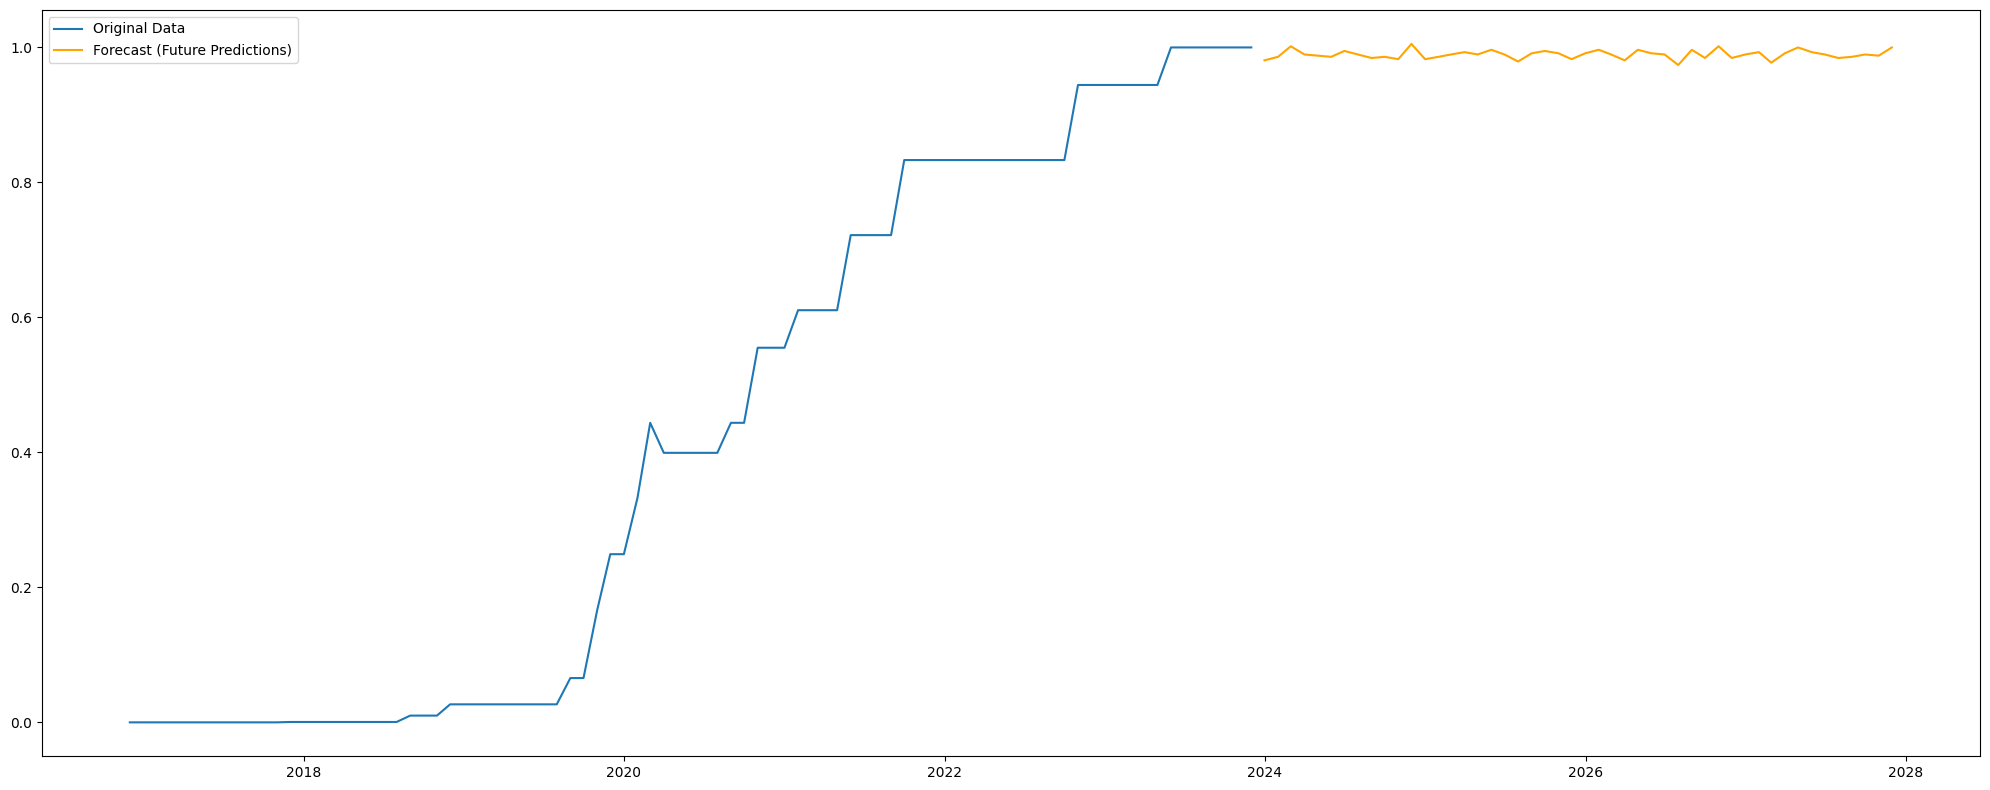

In [181]:
# Calcola le predizioni per periodi futuri (out-of-sample)
future_steps = 48  # Modifica il numero di passi in base alle tue esigenze
exog_values = differenced_series["diff_goal"].values[37:]

forecast_results = results1.get_forecast(steps=future_steps, exog=exog_values)
forecast_results2 = results1.get_forecast(steps=future_steps, exog=exog_values).summary_frame()
print(forecast_results2)

# Estrai le predizioni per periodi futuri
forecast_values = forecast_results.predicted_mean
# Imposta manualmente la frequenza temporale
manual_freq = 'M'  # Modifica in base alla tua frequenza desiderata (es. 'D' per giorni)

# Calcola il passo temporale per la frequenza delle tue date
last_date = differenced_series.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq=manual_freq)
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))

# Original data (assuming your original data is in a variable named 'your_original_data')
ax.plot(differenced_series.index, differenced_series['market_value_in_eur'], label='Original Data')

# Out-of-sample predictions
ax.plot(forecast_index, forecast_values, color='orange', label='Forecast (Future Predictions)')

ax.legend()
plt.tight_layout()
plt.savefig("../../images/forecasat_serie_temp_gol.png")
plt.show()

In [ ]:
# Calcola le predizioni per periodi futuri (out-of-sample)
future_steps = 48  # Modifica il numero di passi in base alle tue esigenze

exog_values = differenced_series[["diff_goal"]].values[136:]

forecast_results = results1.get_forecast(steps=future_steps, exog=exog_values)
forecast_results2 = results1.get_forecast(steps=future_steps, exog=exog_values).summary_frame()
print(forecast_results2)

# Estrai le predizioni per periodi futuri
forecast_values = forecast_results.predicted_mean
# Imposta manualmente la frequenza temporale
manual_freq = 'M'  # Modifica in base alla tua frequenza desiderata (es. 'D' per giorni)

# Calcola il passo temporale per la frequenza delle tue date
last_date = differenced_series.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq=manual_freq)
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))

# Original data (assuming your original data is in a variable named 'your_original_data')
ax.plot(differenced_series.index, differenced_series['market_value_in_eur'], label='Original Data')

# Out-of-sample predictions
ax.plot(forecast_index, forecast_values, color='orange', label='Forecast (Future Predictions)')

ax.legend()
plt.tight_layout()
plt.savefig("../../images/forecasat_serie_temp_gol.png")
plt.show()